# Detailed Mech Simulation

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline

In [2]:
from rmgpy.chemkin import *
from rmgpy.species import Species

In [3]:
from afm.canteraModel import Cantera

/home/yentingw/RMG/RMG-Py/rmgpy/tools/plot.py:31: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/pyth

In [20]:
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)

## 1. specify condition and simulate

In [4]:
model = 'pdd_2014_pruning4_s4_a3ene_c11'

working_dir = os.path.join('../', 'data', 'pdd_chemistry', 'detailed', model)
chemkin_path = os.path.join(working_dir, 'chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'species_dictionary.txt')

In [16]:
speciesList, reactionList = loadChemkinFile(chemkin_path,
                                            species_dict_path)

In [17]:
speciesDict = {}
for spe in speciesList:
    speciesDict[spe.toChemkin()] = spe

In [18]:
# Find the species: ArCCCCR, RCCCCR, RC
pdd = speciesDict['PDD(1)']
reactorTypeList = ['IdealGasConstPressureTemperatureReactor']
molFracList=[{pdd: 1}]
Tlist = ([673.15],'K')
Plist = ([350],'bar')
reactionTimeList = ([3600*14], 's')

In [19]:
job = Cantera(speciesList=speciesList, reactionList=reactionList, outputDirectory='temp_detailed')
job.loadModel()
job.generateConditions(reactorTypeList, reactionTimeList, molFracList, Tlist, Plist)
alldata = job.simulate()

RuntimeError: 
***********************************************************************
CanteraError thrown by Phase::setMoleFractionsByName:
Unknown species 'PDD(1)'
***********************************************************************


## 2. reactant conversion

In [9]:
# prepare moles data
time, dataList, reactionSensitivityData = alldata[0]
TData = dataList[0]
PData = dataList[1]
VData = dataList[2]
total_moles = PData.data*VData.data/8.314/TData.data

NameError: name 'alldata' is not defined

In [12]:
pdd_mf = dataList[7].data
print dataList[7].label
pdd_moles = pdd_mf*total_moles
pdd_conv = (pdd_moles[0]-pdd_moles)/pdd_moles[0]

PDD(1)


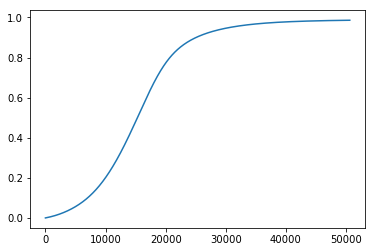

In [22]:
plt.plot(time.data, pdd_conv)
numpy.savetxt(os.path.join(results_path, 'reactant_conv.csv'), (time.data, pdd_conv))

## 3. molecular weight distribution

In [14]:
molecular_weight_distri = []
for mf in dataList[3:]:
    spe = speciesDict[mf.label]
    molecular_weight_distri.append((spe.molecule[0].getMolecularWeight(), mf.data[-1]))

In [17]:
mws = [tup[0]*1000 for tup in molecular_weight_distri]
molefracs = [tup[1] for tup in molecular_weight_distri]

In [19]:
numpy.savetxt(os.path.join(results_path, 'mwd.csv'), (mws, molefracs))